# Progetto preliminare all'esame orale - Data Intensive Application

_Elia Marcantognini matr. 826126_

## Setup

- Importare i package necessari

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os.path
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline

In [2]:
%matplotlib inline

## Analisi e predizione del costo dell'assicurazione medica
- Si fa riferimento a un dataset di pubblico dominio utilizzato come esempio nel libro
    - Machine Learning with R di **Brett Lantz**
- Il dataset è disponibile https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv

### Descrizione del problema
- Si vuole estrarre un modello di conoscenza utile a capire e predire il costo dell'assicurazione medica personale negli Stati Uniti D'America.
- Per farlo sarà necessario capire quanto le singole variabili pesino sul costo.

### Recupero dei dati

In [3]:
if not os.path.exists("insurance.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv",
                "insurance.csv")

In [4]:
insurance = pd.read_csv("insurance.csv")

### Dati

In [5]:
insurance.shape

(1338, 7)

In [6]:
insurance.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
insurance.tail(5)

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


#### Lista delle variabili
- AGE: età del contraente;
- SEX: genere del contraente;
- BMI: indice di massa corporea, utile per capire la fisicità del contraente;
- CHILDREN: numero di figli del contraente;
- SMOKER: indica se il contraente fuma, variabile binaria [yes, no];
- REGION: indica la regione di residenza del contraente;
- **CHARGES**: costo dell'assicurazione medica individuale
    - Lo scopo dell'analisi sarà quello di trovare un modello in grado di predire questa variabile in funzione delle altre.

## Preparazione dei dati

In [8]:
insurance_data = insurance

**Per utilità, convertiamo:**
- La colonna `sex`: 0 per 'female', 1 per 'male'
- La colonna `smoker`: 0 per 'no', 1 per 'yes'
- La colonna `region`: quattro colonne binarie, una per ogni regione

In [9]:
# sex
insurance_data['sex'] = insurance_data['sex'].map({'female':0, 'male':1})
# smoker
insurance_data['smoker'] = insurance_data['smoker'].map({'no':0, 'yes':1})
# region
insurance_data = pd.get_dummies(insurance_data, 'region')
# output
insurance_data.head(5)

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


- Estraiamo dal nostro dataset
    - La Series `y` contenente i valori della colonna `charges` da predire
    - Il DataFrame `X` con i valori di tutte le altre colonne, utili per la predizione

In [10]:
y = insurance_data['charges']
X = insurance_data.drop(columns='charges')

In [11]:
y.head(5)

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

In [12]:
X.head(5)

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,0,0,0,1
1,18,1,33.770,1,0,0,0,1,0
2,28,1,33.000,3,0,0,0,1,0
3,33,1,22.705,0,0,0,1,0,0
4,32,1,28.880,0,0,0,1,0,0


#### Analisi esplorativa

In [13]:
insurance_data.describe()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,13270.422265,0.242152,0.242900,0.272048,0.242900
std,14.049960,0.500160,6.098187,1.205493,0.403694,12110.011237,0.428546,0.428995,0.445181,0.428995
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000
25%,27.000000,0.000000,26.296250,0.000000,0.000000,4740.287150,0.000000,0.000000,0.000000,0.000000
50%,39.000000,1.000000,30.400000,1.000000,0.000000,9382.033000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,16639.912515,0.000000,0.000000,1.000000,0.000000
max,64.000000,1.000000,53.130000,5.000000,1.000000,63770.428010,1.000000,1.000000,1.000000,1.000000


In [14]:
# controllo la presenza di dati NaN
insurance_data.isnull().sum()

age                 0
sex                 0
bmi                 0
children            0
smoker              0
charges             0
region_northeast    0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64

##### Analisi della colonna `age`
- Come si può notare dal grafico, si ha una distribuzione equa delle sottoscrizioni dell'assicurazione medica
- Fatta eccezione per i contraenti con 18 e 19 anni
- Dal terzo grafico si nota come un aumento dell'età comporti proporzionalmente un aumento del costo minimo dell'assicurazione

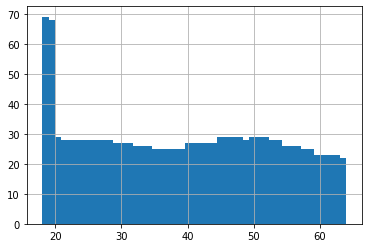

In [15]:
insurance_data.age.hist(bins=47);

In [16]:
insurance_data.loc[insurance.age < 20].age.value_counts()

18    69
19    68
Name: age, dtype: int64

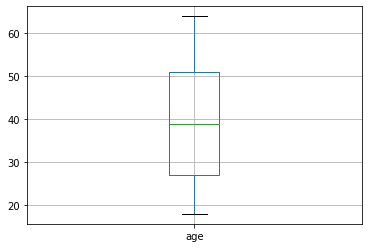

In [59]:
insurance_data.boxplot(column='age')

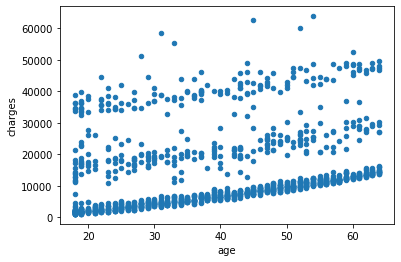

In [17]:
insurance_data.plot.scatter('age', 'charges');

##### Analisi della colonna `bmi`
- L'indice di massa corporea è rappresentativo della fisicità ($\frac{Altezza}{peso^2}$) di una persona
- La maggioranza delle persone prese in esame ha un BMI superiore a `24.9`, indice massimo del normopeso
- Dal secondo grafico si può già notare come un BMI superiore al normopeso possa essere indice di un aumento del costo dell'assicurazione

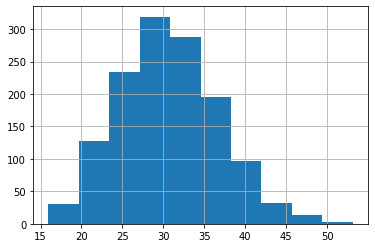

In [18]:
insurance_data.bmi.hist();

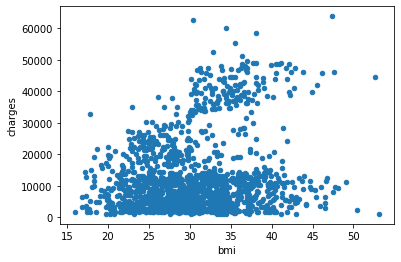

In [19]:
insurance_data.plot.scatter('bmi', 'charges');

##### Analisi della colonna `children`
- La maggiorparte dei soggetti ha 0 figli (42.9%)
- Una minima parte dei soggetti ha fra i 3 e i 5 figli (<15%)

In [20]:
insurance_data['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

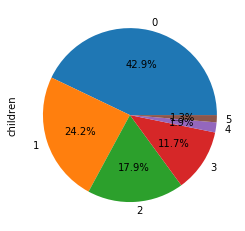

In [21]:
insurance_data['children'].value_counts().plot.pie(autopct='%1.1f%%');

##### Analisi della colonna `smoker`
- La maggioranza dei contraenti non fuma
- Si può notare come un non fumatore abbia un costo minimo di assicurazione minore rispetto al fumatore

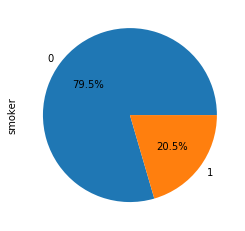

In [22]:
insurance_data.smoker.value_counts().plot.pie(autopct='%1.1f%%');

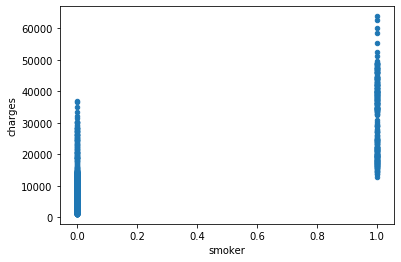

In [23]:
insurance_data.plot.scatter('smoker', 'charges');

##### Analisi della colonna `region`

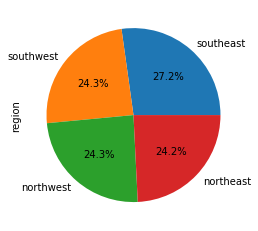

In [25]:
insurance.region.value_counts().plot.pie(autopct='%1.1f%%');

### Correlazioni fra variabili

- Dall'analisi delle varie colonne ci aspettiamo che la colonna `smoker` abbia una correlazione abbastanza marcata con `charges`

In [33]:
# Funzione che calcola il coefficiente di correlazione di Pearson
def correlation(a, b):
    return np.mean((a-a.mean()) * (b-b.mean())) / (a.std() * b.std())

In [34]:
correlation(insurance_data.smoker, insurance_data.charges)

0.7866630512529551

- Come ci aspettavamo, c'è una correlazione diretta fra le due variabili `smoker` e `charges`
- Andiamo nel dettaglio e studiamo l'andamento di `charges` per i fumatori e i non fumatori

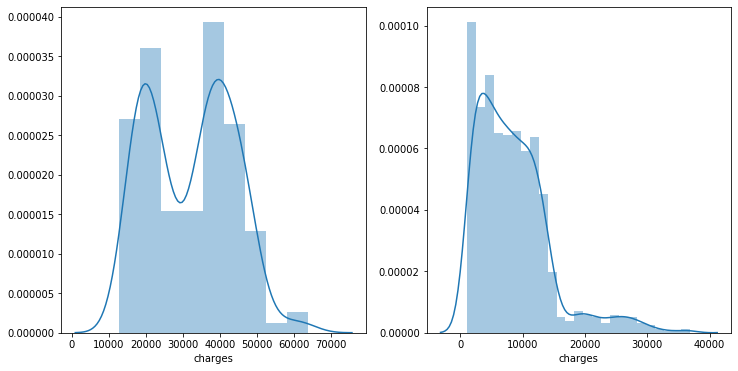

In [61]:
smokers = insurance.loc[insurance_data.smoker == 1]
non_smokers = insurance.loc[insurance_data.smoker == 0]

fig = plt.figure(figsize=(12, 6))

# Distribuzione dei costi per i fumatori
ax = fig.add_subplot(1,2,1)
sns.distplot(smokers['charges'], ax=ax)

# Distribuzione dei costi per i non fumatori
ax = fig.add_subplot(1,2,2)
sns.distplot(non_smokers['charges'], ax=ax);

- Come si può notare, effettivamente i fumatori hanno un costo maggiore rispetto ai non fumatori

### Modelli

- Dividiamo il dataset in training e validation set attraverso il metodo _hold out_

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

- Partiamo alla ricerca del modello migliore partendo da un semplice modello lineare, proseguendo poi con i vari modelli

In [89]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.7650433625569815

In [116]:
lrm = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
lrm.fit(X_train, y_train)
lrm.score(X_val, y_val)

0.7650717650337552

In [117]:
plrm = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])
plrm.fit(X_train, y_train)
plrm.score(X_val, y_val)

0.8544448416983839

In [111]:
model = KernelRidge(alpha=1, kernel='poly', degree=2)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8537902012283942

- La scelta di utilizzare una regressione non lineare è quella con i risultati migliori
- Ora testiamo, utilizzando la Grid Search e la K Fold Validation, il modello per cercare i paremetri migliori (se esistono)

In [128]:
### KFOLD 
kf = KFold(5, shuffle=True, random_state=42)
model = Pipeline([
    ('scaler', StandardScaler()),
    ('regr', KernelRidge(kernel='poly'))
])
grid = {
    'regr__degree': range(1, 5),
    'regr__alpha': [0.01, 0.1, 1, 10]
}
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train)
print(gs.best_params_)
gs.score(X_val, y_val)

{'regr__alpha': 1, 'regr__degree': 2}


0.8544791436845189

- La grid search ci dà la conferma che il risultato migliore si ottiene con un alpha pari a 1 e grado polinomiale pari a 2

In [129]:
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr__alpha,param_regr__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.014561,0.001353,0.006383,0.009283,1,2,"{'regr__alpha': 1, 'regr__degree': 2}",0.884446,0.788276,0.842273,0.866187,0.772676,0.830784,0.043482,1
5,0.015709,0.001336,0.001745,0.000386,0.1,2,"{'regr__alpha': 0.1, 'regr__degree': 2}",0.884956,0.786829,0.843127,0.866233,0.772126,0.830666,0.044095,2
1,0.015393,0.001159,0.001363,0.000450,0.01,2,"{'regr__alpha': 0.01, 'regr__degree': 2}",0.884970,0.786624,0.843177,0.866197,0.772025,0.830611,0.044163,3
14,0.033510,0.003254,0.006383,0.000489,10,3,"{'regr__alpha': 10, 'regr__degree': 3}",0.880217,0.783428,0.836512,0.860185,0.770915,0.826264,0.042594,4
15,0.034109,0.002130,0.005784,0.000746,10,4,"{'regr__alpha': 10, 'regr__degree': 4}",0.880606,0.773912,0.841587,0.858034,0.770029,0.824839,0.044943,5
10,0.035808,0.003831,0.006684,0.001165,1,3,"{'regr__alpha': 1, 'regr__degree': 3}",0.878054,0.768949,0.843547,0.851873,0.764761,0.821441,0.046038,6
13,0.016556,0.002149,0.001995,0.000631,10,2,"{'regr__alpha': 10, 'regr__degree': 2}",0.867637,0.779725,0.823558,0.851177,0.762791,0.816993,0.040267,7
6,0.033317,0.002349,0.007181,0.000746,0.1,3,"{'regr__alpha': 0.1, 'regr__degree': 3}",0.869220,0.756458,0.837826,0.841302,0.759351,0.812832,0.046184,8
2,0.035505,0.001353,0.007380,0.000488,0.01,3,"{'regr__alpha': 0.01, 'regr__degree': 3}",0.867388,0.753680,0.836205,0.839323,0.758365,0.810991,0.046228,9
11,0.037002,0.003709,0.006583,0.001017,1,4,"{'regr__alpha': 1, 'regr__degree': 4}",0.848473,0.744987,0.838033,0.840308,0.755980,0.805536,0.045252,10


0.7650717650337552

In [84]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8544448416983839

In [ ]:
pd.Series(model.coef_, index=X_train.columns)

In [ ]:
pd.Series(model.coef_, index=X_train.columns)